# Parallel Ensembles

This notebook is aimed at showing how to use the parallel and mini-batch variants of the ensembles.

* Examples of all the parallel ensembles available.
* Examples on how to use the parallel versions.
* Example of the trade-off between runtime and accuracy when using the parallel ensembles.

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 25/07/2024**

## 1. Using the most basic bagging ensemble

* **CapyMOA chooses between the standard and the mini-batch version behind the curtains based on the parameter configuration used**

* For more information about the parallel ensembles please refer to the following references: 

`G. Cassales, H. M. Gomes, A. Bifet, B. Pfahringer and H. Senger, Improving the performance of bagging ensembles for data streams through mini-batching, Information Sciences,Volume 580, 2021, Pages 260-282, ISSN 0020-0255, https://doi.org/10.1016/j.ins.2021.08.085.`

`G. Cassales, H. M. Gomes, A. Bifet, B. Pfahringer and H. Senger, "Balancing Performance and Energy Consumption of Bagging Ensembles for the Classification of Data Streams in Edge Computing," in IEEE Transactions on Network and Service Management, vol. 20, no. 3, pp. 3038-3054, Sept. 2023, doi: 10.1109/TNSM.2022.3226505.`

In [1]:
from capymoa.datasets import Covtype
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

cover = Covtype()

ozabag_sequential = OnlineBagging(schema=cover.schema, ensemble_size=10)
ozabag_mb_parallel = OnlineBagging(schema=cover.schema, ensemble_size=10, minibatch_size=25, number_of_jobs=5)

max_instances = 100000
window_size = 5000

In [2]:
# This cell is configured to be hidden on capymoa.org because it is used to
# shorten the duration of the notebook for automated testing purposes.
# See: https://nbsphinx.readthedocs.io/en/0.9.3/hidden-cells.html
from os import environ
if environ.get("NB_FAST", False):
    scale = 1/100
    max_instances = int(max_instances * scale)
    window_size = int(window_size * scale)

### 1.1 Understanding the parameters

- Since we used different parameters in the constructor call, each instace references a different object
	- sequential: note the CLI help only mention `baseLearner` and `ensembleSize`
	- parallel: note the extra parameters `numCores` and `batchSize`
- Setting the parallel parameters on the constructor call will make it a minibatch parallel ensemble.

In [3]:
print(ozabag_sequential.CLI_help())

-l baseLearner (default: trees.HoeffdingTree)
Classifier to train.
-s ensembleSize (default: 10)
The number of models in the bag.



In [4]:
print(ozabag_mb_parallel.CLI_help())

-l baseLearner (default: trees.HoeffdingTree)
Classifier to train.
-s ensembleSize (default: 10)
The number of models in the bag.
-c numCores (default: 1)
The amount of CPU Cores used for multi-threading
-b batchSize (default: 1)
The amount of instances the classifier should buffer before training.



### 1.2 Example comparing sequential and parallel

In [5]:
result_seq = prequential_evaluation(
    stream=cover,
    learner=ozabag_sequential,
    window_size=window_size,
    max_instances=max_instances,
)
result_par = prequential_evaluation(
    stream=cover,
    learner=ozabag_mb_parallel,
    window_size=window_size,
    max_instances=max_instances,
)

result_seq.learner = "OnlineBagging(Seq)"
result_par.learner = "OnlineBagging(Par)"

- Note that the minibatch approach creates a divergence in the results for two reasons:
	1) it uses local random generators instead of a global one;
	2) the mini-batch defers the model update by a few instances which causes differences in the predictions;
- On the bright side, it decreases runtime

Cumulative accuracy = 84.59299999999999
wallclock = 8.727044820785522 seconds

Cumulative accuracy = 83.722
wallclock = 5.640919208526611 seconds



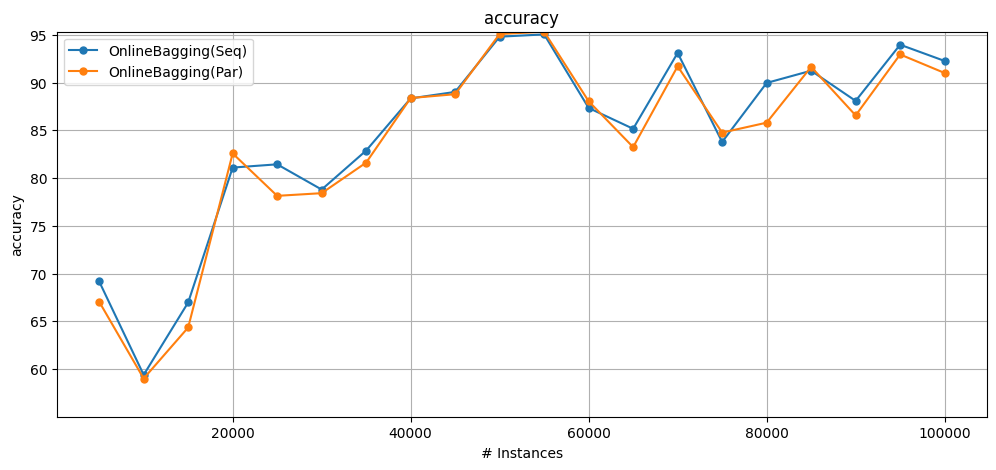

In [6]:
# decoupling the running and plotting to allow more flexibility
print(f"Cumulative accuracy = {result_seq['cumulative'].accuracy()}")
print(f"wallclock = {result_seq['wallclock']} seconds\n")
print(f"Cumulative accuracy = {result_par['cumulative'].accuracy()}")
print(f"wallclock = {result_par['wallclock']} seconds\n")
plot_windowed_results(result_seq, result_par, metric="accuracy")

### 1.3 Increasing the ensemble size
- Ensembles with more learners will get a bigger decrease in processing time.
- Let's see the difference when using 100 classifiers

In [7]:
ozabag_sequential = OnlineBagging(schema=cover.schema, ensemble_size=100)
ozabag_mb_parallel = OnlineBagging(
    schema=cover.schema, ensemble_size=100, minibatch_size=25, number_of_jobs=5
)
result_seq100 = prequential_evaluation(
    stream=cover,
    learner=ozabag_sequential,
    window_size=window_size,
    max_instances=max_instances,
)
result_par100 = prequential_evaluation(
    stream=cover,
    learner=ozabag_mb_parallel,
    window_size=window_size,
    max_instances=max_instances,
)

result_seq100["learner"] = "OnlineBagging100(Seq)"
result_par100["learner"] = "OnlineBagging100(Par)"

TypeError: 'PrequentialResults' object does not support item assignment

In [ ]:
# decoupling the running and plotting to allow more flexibility
print(f"Cumulative accuracy = {result_seq100['cumulative'].accuracy()}")
print(f"wallclock = {result_seq100['wallclock']} seconds\n")
print(f"Cumulative accuracy = {result_par100['cumulative'].accuracy()}")
print(f"wallclock = {result_par100['wallclock']} seconds\n")
plot_windowed_results(result_seq100, result_par100, ylabel="accuracy")

## 2. Other variations

- Sequential execution with the minibatch
- Parallel execution of the incremental approach

In [ ]:
mbSeq = OnlineBagging(schema=cover.get_schema(), ensemble_size=10, minibatch_size=25)
incPar = OnlineBagging(
    schema=cover.get_schema(), ensemble_size=10, minibatch_size=1, number_of_jobs=5
)
result_mbSeq = prequential_evaluation(
    stream=cover, learner=mbSeq, window_size=window_size, max_instances=max_instances
)
result_incPar = prequential_evaluation(
    stream=cover, learner=incPar, window_size=window_size, max_instances=max_instances
)

result_mbSeq.learner = "OnlineBagging(mb_seq)"
result_incPar.learner = "OnlineBagging(inc_par)"

- Incremental Sequential differs from Incremental Parallel because of the random sequences;
- When compared among themselves, mini-batch parallel and mini-batch sequential (single-core) have the same accuracy, as their random sequences are initialized in the same way;
- Incremental Parallel has the same random sequences as the Mini-batch versions, its improvement comes from making all the predictions with the most up-to-date model;


In [ ]:
# decoupling the running and plotting to allow more flexibility
print("Incremental Sequential ")
print(f"Cumulative accuracy = {result_seq['cumulative'].accuracy()}")
print(f"wallclock = {result_seq['wallclock']} seconds\n")
print("Mini-batch Parallel")
print(f"Cumulative accuracy = {result_par['cumulative'].accuracy()}")
print(f"wallclock = {result_par['wallclock']} seconds\n")
print("Mini-batch Sequential")
print(f"Cumulative accuracy = {result_mbSeq['cumulative'].accuracy()}")
print(f"wallclock = {result_mbSeq['wallclock']} seconds\n")
print("Incremental Parallel ")
print(f"Cumulative accuracy = {result_incPar['cumulative'].accuracy()}")
print(f"wallclock = {result_incPar['wallclock']} seconds\n")
plot_windowed_results(result_seq, result_par, result_mbSeq, result_incPar, ylabel="accuracy")

## 3. More ensembles

There are more mini-batch ensembles with parallelism implemented

- AdaptiveRandomForest
- LeveragingBagging
- OzaBagAdwin

In [ ]:
from capymoa.classifier import (
    OnlineAdwinBagging,
    LeveragingBagging,
    AdaptiveRandomForestClassifier,
)

ob_adwin = OnlineAdwinBagging(schema=cover.get_schema(), ensemble_size=30)
lb = LeveragingBagging(schema=cover.get_schema(), ensemble_size=30)
arf = AdaptiveRandomForestClassifier(schema=cover.get_schema(), ensemble_size=30)

results_ob_adwin = prequential_evaluation(
    stream=cover, learner=ob_adwin, window_size=window_size, max_instances=window_size
)
results_lb = prequential_evaluation(
    stream=cover, learner=lb, window_size=window_size, max_instances=window_size
)
results_arf = prequential_evaluation(
    stream=cover, learner=arf, window_size=window_size, max_instances=window_size
)

In [ ]:

print(f"Accuracy {results_ob_adwin['learner']}: {results_ob_adwin['cumulative'].accuracy()}")
print(f"Accuracy {results_lb['learner']}: {results_lb['cumulative'].accuracy()}")
print(f"Accuracy {results_arf['learner']}: {results_arf['cumulative'].accuracy()}")

plot_windowed_results(results_ob_adwin, results_lb, results_arf, ylabel="accuracy")

## 4. Mini-batch size impact

* The greater the mini-batch size the greater the impact on performance (both good and bad)
* Although this behavior can fluctuate during the stream, at the end it is expected that larger mini-batches have slightly smaller runtime and slightly worse accuracy 
	* It becomes slightly faster due to the reuse of data structures in the higher memory hierarchy
	* Predictions are slightly worse due to the larger number of instances predicted with the "outdated" model 
		* Especially in the case of concept drifts, which suffer from the delay in detection and reset of the classifier
	

In [ ]:
ob_adwin_mb50 = OnlineAdwinBagging(
    schema=cover.get_schema(), ensemble_size=30, minibatch_size=50, number_of_jobs=5
)
ob_adwin_mb100 = OnlineAdwinBagging(
    schema=cover.get_schema(), ensemble_size=30, minibatch_size=100, number_of_jobs=5
)
ob_adwin_mb500 = OnlineAdwinBagging(
    schema=cover.get_schema(), ensemble_size=30, minibatch_size=500, number_of_jobs=5
)

results_ob_adwin_mb50 = prequential_evaluation(
    stream=cover,
    learner=ob_adwin_mb50,
    window_size=window_size,
    max_instances=max_instances,
)
results_ob_adwin_mb100 = prequential_evaluation(
    stream=cover,
    learner=ob_adwin_mb100,
    window_size=window_size,
    max_instances=max_instances,
)
results_ob_adwin_mb500 = prequential_evaluation(
    stream=cover,
    learner=ob_adwin_mb500,
    window_size=window_size,
    max_instances=max_instances,
)

results_ob_adwin_mb50["experiment_id"] = "Mini-batch size 50"
results_ob_adwin_mb100["experiment_id"] = "Mini-batch size 100"
results_ob_adwin_mb500["experiment_id"] = "Mini-batch size 500"

In [ ]:
print(f"Accuracy {results_ob_adwin_mb50['experiment_id']}: {results_ob_adwin_mb50['cumulative'].accuracy()}")
print(f"wallclock = {results_ob_adwin_mb50['wallclock']} seconds\n")
print(f"Accuracy {results_ob_adwin_mb100['experiment_id']}: {results_ob_adwin_mb100['cumulative'].accuracy()}")
print(f"wallclock = {results_ob_adwin_mb100['wallclock']} seconds\n")
print(f"Accuracy {results_ob_adwin_mb500['experiment_id']}: {results_ob_adwin_mb500['cumulative'].accuracy()}")
print(f"wallclock = {results_ob_adwin_mb500['wallclock']} seconds\n")

plot_windowed_results(results_ob_adwin_mb50, results_ob_adwin_mb100, results_ob_adwin_mb500, ylabel="accuracy")